In [1]:
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import historical_analysis
from statistics import mean
from standard_precip.spi import SPI

In [2]:

MY_ROOT = pathlib.Path('My_Location_Data')
CLIMATE_VARIABLES = ['pr','tas']
SCENARIOS = ["historical","rcp85"]
MODELS = ["MOHC-HadGEM2-ES","MPI-M-MPI-ESM-LR"]

'''
SELECTION OF VARIABLE
ALSO NEED TO CHANGE VARIABLE IN historical_analysis.py
'''
var = 'pr' 


In [3]:
#Reading model data
for scenario in range(1,2):
    daily_raw_all_model = pd.DataFrame()
    for model in range(2):
        file_name = f"{var}_{MODELS[model]}_{SCENARIOS[scenario]}.txt"
        daily_raw = pd.DataFrame(pd.read_csv(pathlib.Path(MY_ROOT/file_name)))
        daily_raw.columns = ['Date',f"{var}"]
        daily_raw['Scenario'] = SCENARIOS[scenario]
        daily_raw['Model'] = MODELS[model]
        daily_raw_all_model = pd.concat([daily_raw_all_model,daily_raw],axis=0)


daily_raw_all_model['Date'] = pd.DatetimeIndex(daily_raw_all_model['Date'])
daily_raw_all_model['Date'] = pd.to_datetime(daily_raw_all_model['Date']).dt.normalize()
daily_raw_all_model['Year'] = pd.DatetimeIndex(daily_raw_all_model['Date']).year
daily_raw_all_model['Month'] = pd.DatetimeIndex(daily_raw_all_model['Date']).month

In [4]:
'''Near: 2020-2050; Mid: 2040-2070; Far: 2060-2100
'''
def filter_by_period(data,start_year,end_year,desc = None):
    filtered_data = data[(data['Year']>=start_year)&(data['Year']<= end_year)]
    #filtered_data['Period'] = f"{start_year}-{end_year}"
    filtered_data['Period'] = desc
    return filtered_data


In [5]:
near_future = filter_by_period(daily_raw_all_model,2020,2050,'NF')
mid_future = filter_by_period(daily_raw_all_model,2040,2070,'MF')
far_future = filter_by_period(daily_raw_all_model,2060,2100,'FF')


C:\Users\user\AppData\Local\Temp\ipykernel_5988\298072860.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Period'] = desc
C:\Users\user\AppData\Local\Temp\ipykernel_5988\298072860.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Period'] = desc
C:\Users\user\AppData\Local\Temp\ipykernel_5988\298072860.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [6]:
observed = pd.read_csv(f"{MY_ROOT}/{var}_observed.csv")
observed.columns = ['Date',var]
observed['Date'] = pd.DatetimeIndex(observed['Date'])
observed['Year'] = pd.DatetimeIndex(observed['Date']).year
observed['Month'] = pd.DatetimeIndex(observed['Date']).month
observed['Model'] = 'Observed'

if var == 'pr':
    observed_year_month = historical_analysis.grouped_by_year_month_observed_pr.copy()
    observed_year_month.columns = ['Year','Month',var,'Year-Month']
else:
    observed_year_month = historical_analysis.grouped_by_year_month_observed_tas.copy()
    observed_year_month.columns = ['Year','Month',var,'Year-Month']

observed_year_month.drop('Year-Month',inplace=True,axis=1)

In [7]:

if var =='pr':
    yearly_average_rcp85 = daily_raw_all_model.groupby(by=['Year','Model'])[var].sum().reset_index()
    yearly_average_observed = observed.groupby(by=['Year','Model'])[var].sum().reset_index()
    year_month_historical_model = historical_analysis.grouped_by_year_month_model_pr
    year_month_rcp85 = daily_raw_all_model.groupby(by=['Year','Month','Model'])[var].sum().reset_index()
    #year_month_rcp85 = year_month_rcp85.groupby(by=['Year','Month'])[var].mean().reset_index()
else:
    yearly_average_rcp85 = daily_raw_all_model.groupby(by=['Year','Model'])[var].mean().reset_index()
    yearly_average_observed = observed.groupby(by=['Year','Model'])[var].mean().reset_index()
    year_month_historical_model = historical_analysis.grouped_by_year_month_model_tas
    year_month_rcp85 = daily_raw_all_model.groupby(by=['Year','Month','Model'])[var].mean().reset_index()

year_month_rcp85_ensemble = year_month_rcp85.groupby(by=['Year','Month'])[var].mean().reset_index()

yearly_average_ensemble_rcp85 = yearly_average_rcp85.groupby(by='Year')[var].mean().reset_index()
#yearly_average_obs_rcp85 = pd.concat([yearly_average_observed,yearly_average_rcp85],ignore_index=True)
yearly_average_model_historical = historical_analysis.grouped_by_year_model_pr if var == 'pr' else  historical_analysis.grouped_by_year_model_tas

yearly_average_ensemble_historical = yearly_average_model_historical.groupby(by='Year')[var].mean().reset_index()

lt_avg_ensemble_historical = yearly_average_ensemble_historical[var].mean()
lt_avg_observed = yearly_average_observed[var].mean()
lt_stdev_ensemble_historical = yearly_average_ensemble_historical[var].std()
avg_10_highest_historical = mean(sorted(yearly_average_ensemble_historical[var], reverse=True)[:10])
avg_10_lowest_historical = mean(sorted(yearly_average_ensemble_historical[var],reverse=False)[:10])

yearly_average_ensemble_rcp85['Deviation'] = (yearly_average_ensemble_rcp85[var]- lt_avg_ensemble_historical)
condition_positive = yearly_average_ensemble_rcp85['Deviation'] > 0
condition_negative = ~condition_positive

if var == 'pr':
    yearly_average_ensemble_rcp85['RAI'] = (3* yearly_average_ensemble_rcp85['Deviation']/(
        avg_10_highest_historical-lt_avg_ensemble_historical)).where(
            condition_positive,-3 * yearly_average_ensemble_rcp85['Deviation']/(
                avg_10_lowest_historical-lt_avg_ensemble_historical))
    condition = np.where(yearly_average_ensemble_rcp85['RAI']>0,'wet','dry')
    yearly_average_ensemble_rcp85['Condition'] = condition
    yearly_average_ensemble_rcp85['Deviation'] = yearly_average_ensemble_rcp85['Deviation']/lt_avg_ensemble_historical * 100
else:
    #yearly_average_ensemble_rcp85['LtAvg'] = lt_avg_ensemble_historical 
    yearly_average_ensemble_rcp85['Deviation']= yearly_average_ensemble_rcp85[var]- lt_avg_ensemble_historical


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

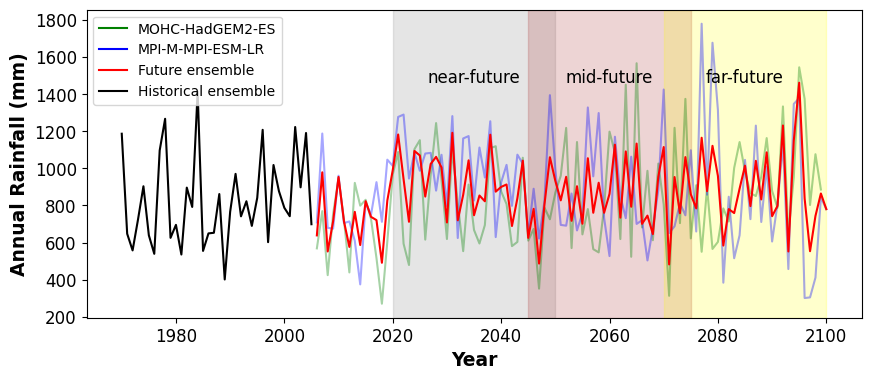

In [8]:
def plot_annual_trend():
    fig,ax = plt.subplots(figsize = (10,4))
    sns.lineplot(yearly_average_rcp85,x='Year',y=var,hue='Model',palette=['green','blue'], alpha = 0.35)
    #plt.fill_between(yearly_average_rcp85['Year'], yearly_average_rcp85[var], alpha=0.2)

    sns.lineplot(yearly_average_ensemble_rcp85,x='Year',y = var,color = 'red',label = "Future ensemble")
    sns.lineplot(yearly_average_ensemble_historical,x = 'Year',y = var,color = 'black',label = 'Historical ensemble')
    # Draw a vertical shaded region
    plt.axvspan(xmin=2020, xmax=2050, alpha=0.2, color='gray')
    plt.axvspan(xmin= 2045,xmax=2075, alpha =0.2, color = 'brown' )
    plt.axvspan(xmin = 2070,xmax=2100,alpha = 0.2, color ='yellow')
    # Add text to the plot
    plt.text(2035, max(yearly_average_ensemble_rcp85[var]), 'near-future', fontsize=12, ha='center')
    plt.text(2060, max(yearly_average_ensemble_rcp85[var]), 'mid-future', fontsize=12, ha='center')
    plt.text(2085, max(yearly_average_ensemble_rcp85[var]), 'far-future', fontsize=12, ha='center')
    #sns.lineplot(observed,x='Year',y = var,color = 'black',label = "Observed")
    plt.xlabel('Year',fontweight = 'bold',fontsize = 13.5, color = 'black')
    plt.ylabel(f'Annual Rainfall (mm)'if var == 'pr' else f'Avg. Surface Temperature (°C)', fontweight = 'bold',fontsize = 13.5, color = 'black')
    plt.xticks(fontsize = 12,color = 'black')
    plt.yticks(fontsize = 12, color = 'black')
plot_annual_trend()

In [9]:
def plot_anamoly():
    fig,ax = plt.subplots(figsize = (10,5))
    sns.barplot(filter_by_period(yearly_average_ensemble_rcp85,2020,2100),
                x = 'Year',
                y = 'RAI' if var == 'pr' else 'Deviation' , 
                hue = 'Condition' if var == 'pr' else None,
                palette=['blue','red'] if var == 'pr' else None,
                color = None if var == 'pr' else 'red',
                dodge=False )
    plt.ylabel('Rainfall Anamoly Index (RAI)' if var == 'pr' else 'Avg. Surface Temperature Anamoly (°C)', fontweight = 'bold',fontsize = 13.5, color = 'black')
    plt.xlabel('Year', fontweight = 'bold',fontsize = 13.5, color = 'black')
    plt.gca().set_xticks(plt.gca().get_xticks()[::5])
    plt.legend().set_visible(False)
    plt.xticks(fontsize = 11,color = 'black')
    plt.yticks(fontsize = 11, color = 'black')
plot_anamoly()


In [10]:

NF = filter_by_period(yearly_average_ensemble_rcp85,2020,2050)['Deviation'].mean()
MF = filter_by_period(yearly_average_ensemble_rcp85,2045,2070)['Deviation'].mean()
FF = filter_by_period(yearly_average_ensemble_rcp85,2065,2100)['Deviation'].mean()

lt_change_summary = pd.DataFrame({'Observed Historical':[lt_avg_observed],
                                  'Modeled Historical':[lt_avg_ensemble_historical],
                                  'NF':[NF],'MF':[MF],'FF':[FF]})

C:\Users\user\AppData\Local\Temp\ipykernel_5988\298072860.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Period'] = desc
C:\Users\user\AppData\Local\Temp\ipykernel_5988\298072860.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Period'] = desc
C:\Users\user\AppData\Local\Temp\ipykernel_5988\298072860.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [11]:
lt_change_summary

,Observed Historical,Modeled Historical,NF,MF,FF
0,1646.997222,825.458331,9.449018,3.439328,7.068492


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option i

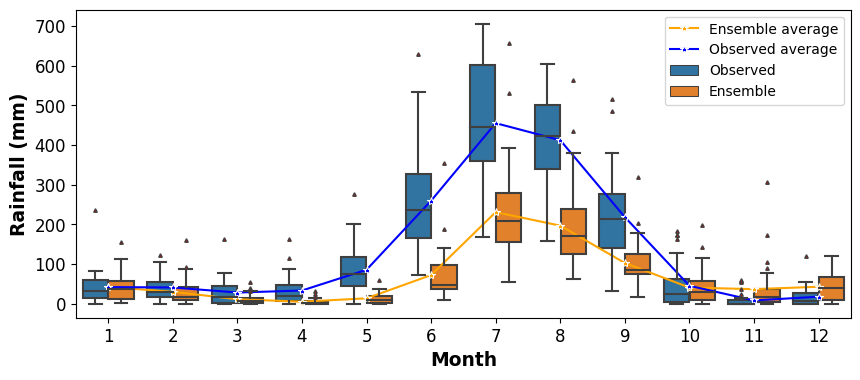

In [12]:

if var == 'pr':
    monthly_avg_model_ensemble = historical_analysis.grouped_by_month_model_pr.groupby(by='Month')[var].mean().reset_index()
    historical_year_month_ensemble = historical_analysis.grouped_by_year_month_model_pr.groupby(by = ['Year','Month'])[var].mean().reset_index()
else:
    monthly_avg_model_ensemble = historical_analysis.grouped_by_month_model_tas.groupby(by='Month')[var].mean().reset_index()
    historical_year_month_ensemble = historical_analysis.grouped_by_year_month_model_tas.groupby(by = ['Year','Month'])[var].mean().reset_index()


def plot_boxplots_for_historical_comparision():
    fig,ax = plt.subplots(figsize = (10,4))
    
    historical_year_month_ensemble['Type']= 'Ensemble'
    observed_year_month['Type'] = 'Observed'
    for_box_plot_merged_model_observed = pd.concat([observed_year_month,historical_year_month_ensemble],ignore_index=True)
    #
    sns.lineplot(monthly_avg_model_ensemble[var],
                ax = ax,
                color = 'orange',
                marker = '*',
                label = 'Ensemble average')
    
    sns.lineplot(historical_analysis.grouped_by_month_obs_pr['s406'] if var == 'pr' else historical_analysis.grouped_by_month_observed_tas['s406'],
                ax= ax,
                color = 'blue',
                marker ='*',
                label = 'Observed average')
    
    sns.boxplot(for_box_plot_merged_model_observed,x = 'Month', y = var,
                #boxprops=dict(facecolor= None,edgecolor ='black'),
                #whiskerprops = dict(color='black'),
                #capprops=dict(color='black'),
                # medianprops = dict(color ='black'),
                flierprops = dict(marker ='^',markerfacecolor = 'red', markersize = 2.5),
                hue='Type', palette=None,
                ax= ax)
    plt.xlabel('Month',fontweight = 'bold',fontsize = 13.5, color = 'black')
    plt.ylabel ('Rainfall (mm)' if var == 'pr' else 'Avg. Surface Temperature (°C)',fontweight = 'bold', fontsize = 13.5, color = 'black')
    plt.legend()
    plt.xticks(fontsize = 12,color = 'black')
    plt.yticks(fontsize = 12, color = 'black')

plot_boxplots_for_historical_comparision()

In [13]:
monthly_correlation = observed_year_month[var].corr(historical_year_month_ensemble[var])
monthly_correlation

0.6570057582882638

In [14]:
def percentage_bias(observed, modeled):
    """
    Calculate Percentage Bias between observed and modeled values.
    
    Parameters:
    - observed: array-like, observed values
    - modeled: array-like, modeled values
    
    Returns:
    - PBIAS: Percentage Bias
    """
    observed = np.array(observed)
    modeled = np.array(modeled)
    
    numerator = np.sum(modeled - observed)
    denominator = np.sum(observed)
    
    pbias = (numerator / denominator) * 100
    return pbias

pbias = percentage_bias(observed=observed_year_month[var],
                        modeled=historical_year_month_ensemble[var] if var == 'pr' else historical_year_month_ensemble[var][36:])
pbias

-49.88101258026407

In [15]:
from sklearn.metrics import r2_score

def nash_sutcliffe_efficiency(observed, modeled):
    """
    Calculate Nash–Sutcliffe efficiency using scikit-learn's r2_score.
    
    Parameters:
    - observed: array-like, observed values
    - modeled: array-like, modeled values
    
    Returns:
    - NSE: Nash–Sutcliffe efficiency
    """
    r2 = r2_score(observed, modeled)
    nse = 1 - (1 / r2)
    return r2, nse

r2, nse = nash_sutcliffe_efficiency(observed_year_month[var],
                                    historical_year_month_ensemble[var] if var == 'pr' else historical_year_month_ensemble[var][36:])

r2,nse

(0.25719100118158067, -2.8881609208946823)

In [16]:
def assign_season(df):
    month_to_season = {
        1:'Winter',2:'Winter',3:'Spring',4:'Spring',
        5:'Spring',6:'Summer',7:'Summer',8:'Summer',
        9:'Autumn',10:'Autumn',11:'Autumn',12:'Winter'
    }
    df['Season'] = df['Month'].map(month_to_season)
    return df 

historical_year_month_ensemble_with_season = assign_season(historical_year_month_ensemble)

if var == 'pr':
    historical_seasonal_average = historical_year_month_ensemble_with_season.groupby(
        by =['Year','Season'])[var].sum().reset_index().groupby(
            by='Season')[var].mean().reset_index().set_index('Season')[var].to_dict()
else:
    historical_seasonal_average = historical_year_month_ensemble_with_season.groupby(
        by =['Year','Season'])[var].mean().reset_index().groupby(
        by='Season')[var].mean().reset_index().set_index('Season')[var].to_dict()

def seasonal_change(baseline_average,projected_year_month):
    projected_with_season = assign_season(projected_year_month)
    projected_with_season_grouped = projected_with_season.groupby(by = ['Year','Season','Period'])[var].sum().reset_index() if var == 'pr' else projected_with_season.groupby(by = ['Year','Season','Period'])[var].mean().reset_index()
    projected_with_season_grouped['LtAvg'] = projected_with_season_grouped['Season'].map(baseline_average)
    projected_with_season_grouped['Deviation'] = (projected_with_season_grouped[var]-projected_with_season_grouped['LtAvg'])/projected_with_season_grouped['LtAvg'] *100 if var == 'pr' else projected_with_season_grouped[var]-projected_with_season_grouped['LtAvg']
    return projected_with_season_grouped




In [17]:

NF_seasonal_change = seasonal_change(historical_seasonal_average,filter_by_period(year_month_rcp85_ensemble,start_year=2020,end_year=2050,desc='near-future'))
MF_seasonal_change = seasonal_change(historical_seasonal_average,filter_by_period(year_month_rcp85_ensemble,start_year=2045,end_year=2070,desc='mid-future'))
FF_seasonal_change = seasonal_change(historical_seasonal_average,filter_by_period(year_month_rcp85_ensemble,start_year=2065,end_year=2100,desc='far-future'))

all_periods_seasonal_change = pd.concat([NF_seasonal_change,MF_seasonal_change,FF_seasonal_change],ignore_index=True)

C:\Users\user\AppData\Local\Temp\ipykernel_5988\298072860.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Period'] = desc
C:\Users\user\AppData\Local\Temp\ipykernel_5988\264388673.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Season'] = df['Month'].map(month_to_season)
C:\Users\user\AppData\Local\Temp\ipykernel_5988\298072860.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

(array([-200., -100.,    0.,  100.,  200.,  300.,  400.,  500.]),
 [Text(0, -200.0, '−200'),
  Text(0, -100.0, '−100'),
  Text(0, 0.0, '0'),
  Text(0, 100.0, '100'),
  Text(0, 200.0, '200'),
  Text(0, 300.0, '300'),
  Text(0, 400.0, '400'),
  Text(0, 500.0, '500')])

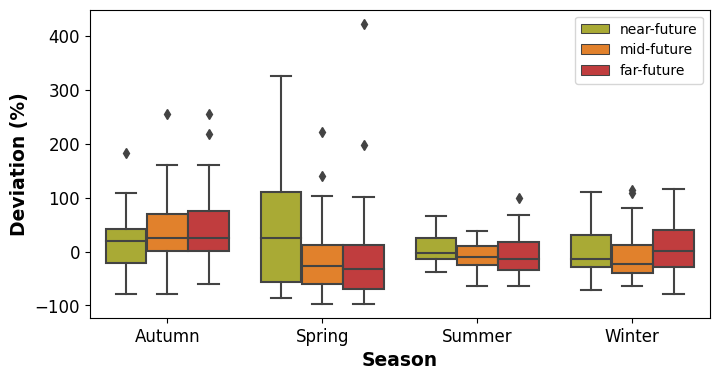

In [27]:
fig, ax = plt.subplots(figsize = (8,4))
sns.boxplot(all_periods_seasonal_change,x='Season',y='Deviation',hue='Period',
            palette=[sns.color_palette()[8],sns.color_palette()[1], sns.color_palette()[3]])
plt.xlabel('Season', fontweight ='bold', fontsize = 13.5, color = 'black')
plt.ylabel('Deviation (%)' if var == 'pr' else 'Deviation (°C)',fontweight = 'bold', fontsize = 13.5, color = 'black')
plt.legend()
plt.xticks(fontsize = 12,color = 'black')
plt.yticks(fontsize = 12, color = 'black')

In [19]:
#Extreme analysis
def extremes_(data,start,end):
    save_extremes_here = []
    for year in range(start,end+1):
        one_year = filter_by_period(data,year,year).groupby(by = ['Date','Year'])[var].mean().reset_index()
        rx1day = one_year[var].max()
        rx5day = one_year[var].rolling(5).sum().max() if var == 'pr' else one_year[var].min()
        temp_row = [year,rx1day,rx5day] 
        save_extremes_here.append(temp_row)
    
    df = pd.DataFrame(save_extremes_here)
    df.columns = ['Year','annual-1-day-max-pr (mm)','annual-5-day-max-pr (mm)'] if var == 'pr' else ['Year','annual-daily-max-tas(°C)','annual-daily-min-tas(°C)']
    return df

C:\Users\user\AppData\Local\Temp\ipykernel_5988\298072860.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Period'] = desc
C:\Users\user\AppData\Local\Temp\ipykernel_5988\298072860.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Period'] = desc
C:\Users\user\AppData\Local\Temp\ipykernel_5988\298072860.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

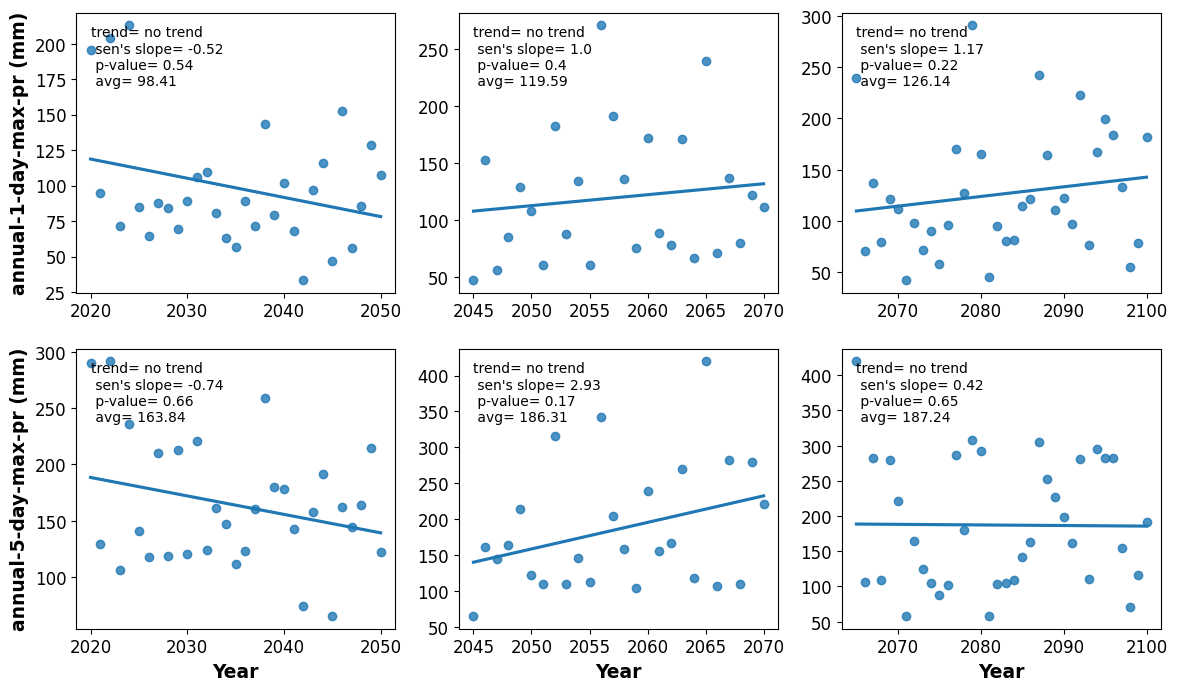

In [20]:
from pymannkendall import original_test

fig,ax = plt.subplots(nrows=2,ncols=3,figsize = (14,8))
start = [2020,2045,2065]
end = [2050,2070,2100]
indices = ['annual-1-day-max-pr (mm)','annual-5-day-max-pr (mm)'] if var == 'pr' else ['annual-daily-max-tas(°C)','annual-daily-min-tas(°C)']

#for j in range(2):
for j in range(2):
    for i in range(3):
        extremes_values = extremes_(daily_raw_all_model,start[i],end[i])
        avg_of_extremes = extremes_values[indices[j]].mean()
        man= original_test(x_old=extremes_values[indices[j]],alpha=0.05)
        sns.regplot(extremes_values,x='Year',y=indices[j],ci =None,ax=ax[j,i])
        text_x_fraction = 0 # Adjust this value based on your preference
        text_x = extremes_values['Year'].min() + text_x_fraction * (extremes_values['Year'].max() - extremes_values['Year'].min())
        text_y = extremes_values[indices[j]].max()  # Use the maximum y-value in the data
        ax[j,i].text(x=text_x, y=text_y, s=f"trend= {man[0]}\n sen's slope= {man[7].__round__(2)}\n p-value= {man[2].__round__(2)}\n avg= {avg_of_extremes.__round__(2)}", ha='left', va='top')  # Adjust alignment as needed
        ax[j, i].tick_params(axis='x', labelsize=12, color='black')
        ax[j, i].tick_params(axis='y', labelsize=12, color='black')
        ax[j, i].set_xlabel('')
        ax[j, i].set_ylabel('')
        if (i == 0):
            ax[j, i].set_ylabel(ylabel = indices[j],fontsize=13.5, color='black', fontweight ='bold')
        if j ==1:
            ax[j, i].set_xlabel(xlabel = 'Year',fontsize=13.5, color='black',fontweight ='bold')
            
plt.savefig(f'{var}_extremes.png',dpi = 300)
    




C:\Users\user\AppData\Local\Temp\ipykernel_5988\298072860.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Period'] = desc
C:\Users\user\AppData\Local\Temp\ipykernel_5988\298072860.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Period'] = desc
C:\Users\user\AppData\Local\Temp\ipykernel_5988\298072860.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

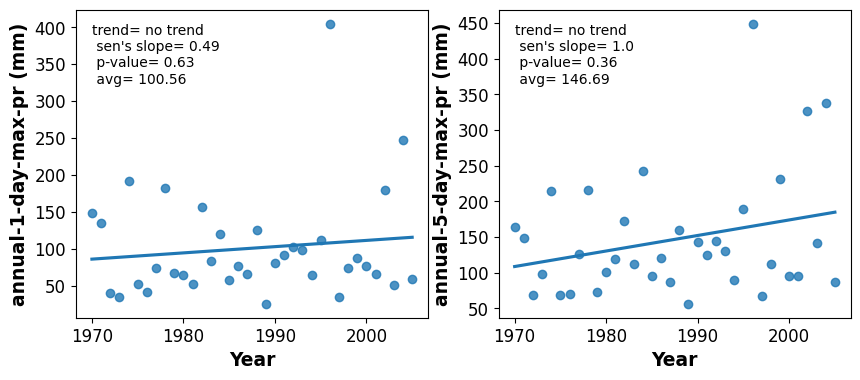

In [21]:
historical_data = historical_analysis.daily_raw_all_model.copy()
fig,ax1 = plt.subplots(nrows=1, ncols=2, figsize = (10,4))
for i in range(2):
    extremes_values = pd.DataFrame(extremes_(historical_data,1970,2005))
    avg_of_extremes = extremes_values[indices[i]].mean()
    man= original_test(x_old=extremes_values[indices[i]],alpha=0.05)
    sns.regplot(data = extremes_values,x='Year',y= indices[i] ,ci =None,ax=ax1[i])
    text_x_fraction = 0 # Adjust this value based on your preference
    text_x = extremes_values['Year'].min() + text_x_fraction * (extremes_values['Year'].max() - extremes_values['Year'].min())
    text_y = extremes_values[indices[i]].max()  # Use the maximum y-value in the data
    ax1[i].text(x=text_x, y=text_y, s=f"trend= {man[0]}\n sen's slope= {man[7].__round__(2)}\n p-value= {man[2].__round__(2)}\n avg= {avg_of_extremes.__round__(2)}", ha='left', va='top')  # Adjust alignment as needed
    ax1[i].tick_params(axis='x', labelsize=12, color='black')
    ax1[i].tick_params(axis='y', labelsize=12, color='black')
    ax1[i].set_xlabel('')
    ax1[i].set_ylabel('')
    ax1[i].set_ylabel(ylabel = indices[i],fontsize=13.5, color='black', fontweight = 'bold')
    ax1[i].set_xlabel(xlabel = 'Year',fontsize=13.5, color='black', fontweight ='bold')
           
plt.savefig(f'{var}_historical_extremes.png',dpi = 300)

C:\Users\user\AppData\Local\Temp\ipykernel_5988\298072860.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Period'] = desc


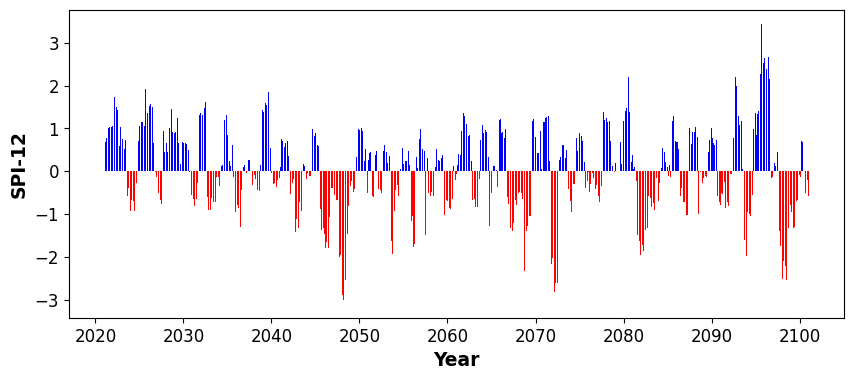

In [26]:
def plot_spi():
    spi = SPI()
    fig,ax = plt.subplots(1,1,figsize = (10,4))
    for i in range(1):
        for_spi_calc = filter_by_period(daily_raw_all_model,2020,2100)
        for_spi_calc = for_spi_calc.groupby(by = ['Date'])[var].mean().reset_index()
        for_spi_calc.set_index('Date',inplace=True)
        for_monthly_spi = for_spi_calc[var].resample('M').sum().reset_index()
        df_spi = spi.calculate(
            for_monthly_spi, 
            'Date', 
            var, 
            freq="M", 
            scale=12, 
            fit_type="lmom", 
            dist_type="gam"
        )
        pos_index = df_spi.loc[df_spi['pr_scale_12_calculated_index'] >= 0]
        neg_index = df_spi.loc[df_spi['pr_scale_12_calculated_index'] < 0]

        ax.bar(pos_index['Date'], pos_index['pr_scale_12_calculated_index'],width =20, align='center', color='b')
        ax.bar(neg_index['Date'], neg_index['pr_scale_12_calculated_index'],width =20, align='center', color='r')
        ax.grid(True)
       
        ax.set_xlabel("Year",fontsize = 13.5,color = 'black',fontweight = 'bold')
        if i == 0:
            ax.set_ylabel('SPI-12',fontsize = 13.5,color = 'black',fontweight ='bold')
        ax.tick_params(axis='x', labelsize=12, color='black')
        ax.tick_params(axis='y', labelsize=12, color='black')
        #ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.grid(False)
        #plt.tight_layout()
plot_spi()

C:\Users\user\AppData\Local\Temp\ipykernel_6724\298072860.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Period'] = desc
C:\Users\user\AppData\Local\Temp\ipykernel_6724\298072860.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Period'] = desc
C:\Users\user\AppData\Local\Temp\ipykernel_6724\298072860.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

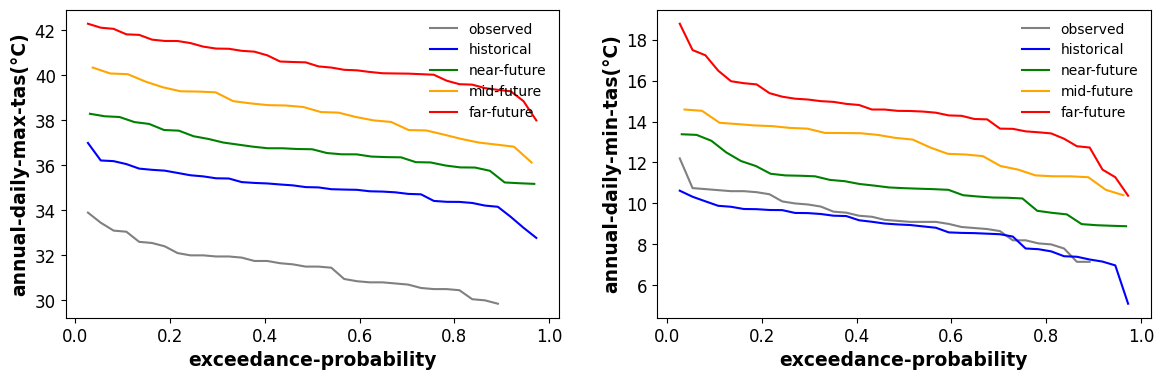

In [ ]:

def frequency_analysis(data_extremes,index):
    #data_extremes = extremes_(data,start=1970,end=2005)
    sorted_extremes = data_extremes.sort_values(by = indices[index],ascending=False)
    sorted_extremes['Rank'] = np.arange(1,data_extremes.shape[0]+1)
    sorted_extremes['exceedance-probability'] = sorted_extremes['Rank']/(sorted_extremes.shape[0]+1)
    sorted_extremes['return-period'] = 1/sorted_extremes['exceedance-probability']
    return sorted_extremes

#index = 0
fig, ax = plt.subplots(nrows=1,ncols=2,figsize = (14,4))
for index in range(2): 
    hist_freq = frequency_analysis(extremes_(historical_analysis.daily_raw_all_model,1970,2005), index=index)
    NF_freq = frequency_analysis(extremes_(daily_raw_all_model,2020,2050),index= index)
    MF_freq = frequency_analysis(extremes_(daily_raw_all_model,2045,2070),index=index)
    FF_freq = frequency_analysis(extremes_(daily_raw_all_model,2065,2100),index=index)
    observed_freq = frequency_analysis(extremes_(observed,1970,2005),index= index)
    sns.lineplot(data = observed_freq, x = 'exceedance-probability', y = indices[index],label = 'observed',color = 'grey',ax = ax[index])
    sns.lineplot(data=hist_freq, x = 'exceedance-probability', y= indices[index],label = 'historical',color = 'blue', ax=ax[index])
    sns.lineplot(data = NF_freq,x = 'exceedance-probability',y =indices[index],label ='near-future',color = 'green', ax=ax[index])
    sns.lineplot(data = MF_freq,x= 'exceedance-probability',y =indices[index],label = 'mid-future',color = 'orange', ax=ax[index])
    sns.lineplot(data = FF_freq,x = 'exceedance-probability',y =indices[index],label = 'far-future',color = 'red', ax=ax[index])
    ax[index].legend(frameon = False, loc = 'upper right')
    ax[index].tick_params(axis='x', labelsize=12, color='black')
    ax[index].tick_params(axis='y', labelsize=12, color='black')
    ax[index].set_xlabel(xlabel = 'exceedance-probability', fontsize = 13.5,color = 'black', fontweight ='bold')
    ax[index].set_ylabel(ylabel = indices[index], fontsize = 13.5,color = 'black',fontweight ='bold')
    
    